In [11]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from PIL import Image

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
print('GPUs available: {}'.format(len(tf.config.list_physical_devices('GPU'))))

2.2.0
GPUs available: 1


In [12]:
# Define the features in the TFRecords file
features = {
    "image_raw": tf.io.FixedLenSequenceFeature(
        [], dtype=tf.float32, allow_missing=True
    ),
    "height": tf.io.FixedLenFeature([], tf.int64),
    "width": tf.io.FixedLenFeature([], tf.int64),
    "channels": tf.io.FixedLenFeature([], tf.int64),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

In [21]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    height = tf.cast(image_features["height"], tf.int32)
    width = tf.cast(image_features["width"], tf.int32)
    channels = tf.cast(image_features["channels"], tf.int32)
    
    image_raw = tf.reshape(
        tf.squeeze(image_features["image_raw"]),
        tf.stack([height, width, channels])
    )
    
    target = image_features["label"]
    
    return image_raw, target

In [25]:
data = tf.data.TFRecordDataset("data/UCM.tfrecords").map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

data_viz = iter(data.batch(1))

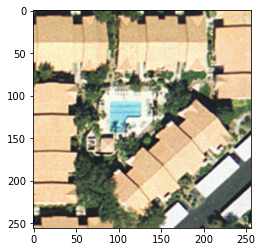

In [26]:
img, _ = next(data_viz)
plt.imshow(img.numpy()[0])